Here I look at by-frequency sliding window elasticity results for the CVK Virchow test-retest set. I compared HMDI and MREdge-MDEV (called here HELM). The only difference between them was inversion method -- all other pre-processing was identical.

In [401]:
%matplotlib inline
import numpy as np
import pandas as pd
import os

WIDEBAND_RESULTS_PATH = '/media/ericbarnhill/backup/projects/2018-03-12-virchow/results_wideband/'
NARROWBAND_RESULTS_PATH = '/media/ericbarnhill/backup/projects/2018-03-12-virchow/results_narrowband/'

FREQ_INDEX = 1

In [402]:
def process_results(RESULTS_PATH):
    mredge_medians = []
    for dir in os.listdir(RESULTS_PATH):
        file_path = os.path.join(RESULTS_PATH, dir , 'stats/medians.csv')
        mredge_medians_subj = pd.read_csv(file_path, header=None)
        medians_shape = mredge_medians_subj.shape
        ID_comps = dir.split('_')
        subj = ID_comps[2]
        acq_num = int(ID_comps[1])
        cond = 'before' if acq_num < 7 else 'after'
        # tile subject-specific information to create tall format data
        tile_dims = [medians_shape[0], 1]
        subj_id = np.tile(dir, tile_dims)
        subj_cond= np.tile(subj + '_' + cond, tile_dims)
        subj= np.tile(subj, tile_dims)
        cond = np.tile(cond, tile_dims)
        freq_test = mredge_medians_subj.iloc[:,FREQ_INDEX].apply(lambda entry: len(str.split(entry, '_')))
        mredge_medians_subj['subj_id'] = subj_id
        mredge_medians_subj['subj'] = subj
        mredge_medians_subj['cond'] = cond
        mredge_medians_subj['subj_cond'] = subj_cond
        mredge_medians_subj['freq_test'] = freq_test
        mredge_medians_subj['cond_ID'] = mredge_medians_subj['cond'] == 'after'
        col_names = ['method', 'freqs', 'G', 'Norm_Var', 'subj_ID', 'subj', 'cond', 'subj_cond', 
                     'freq_test', 'cond_ID']
        #col_names = ['method', 'freqs', 'G', 'Norm_Var', 'subj_ID', 'subj', 'cond', 'subj_cond']
        mredge_medians_subj.columns = col_names
        mredge_medians_subj = mredge_medians_subj.drop(columns=['Norm_Var'])
        mredge_medians.append(mredge_medians_subj)
    mredge_medians = pd.concat(mredge_medians)
    mredge_medians = mredge_medians.drop_duplicates()
    mredge_medians.freqs = mredge_medians.freqs.apply(str.strip)
    alls = mredge_medians.freqs == 'ALL'
    mredge_medians.loc[alls,'freq_test'] = 0
    #mredge_medians = mredge_medians.loc[mredge_medians.method != 'phi']
    mredge_medians.loc[mredge_medians.method == 'sfwi', 'method'] = 'hmdi'
    mredge_medians.loc[mredge_medians.method == 'absg', 'method'] = 'helm'
    return(mredge_medians)

In [587]:
g_medians = process_results(WIDEBAND_RESULTS_PATH)

# Wideband sliding windows

Elasticity results for each subject at each sliding frequency window are shown below. Test is continuous line and retest is dashed. 

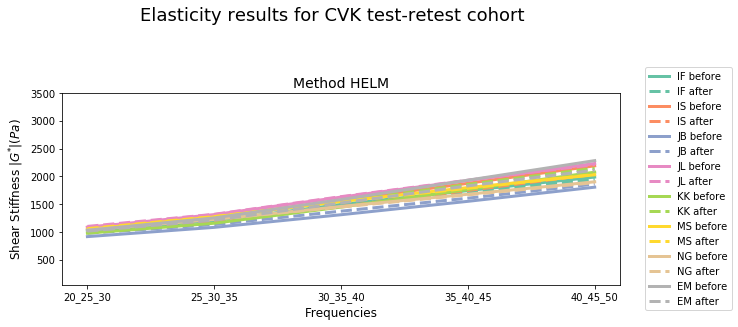

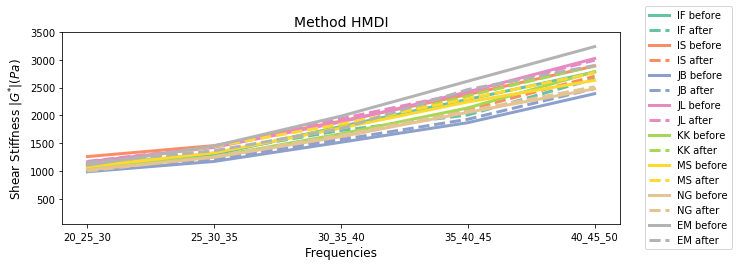

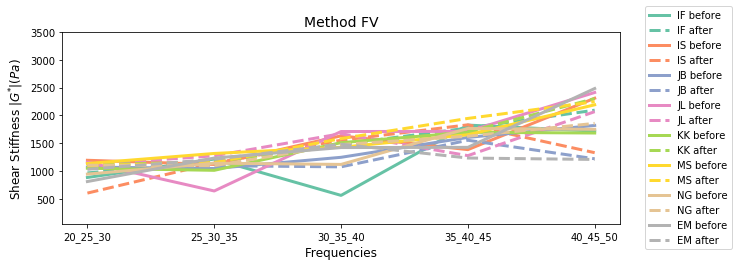

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
plt.rcParams["figure.figsize"] = (10,12)

# globals for plotting
color_scheme = sns.color_palette("Set2", len(g_medians.subj.unique()))
color_scheme_expanded = [col for col in color_scheme for _ in (0, 1)]
names_expanded = [name for name in g_medians.subj.unique() for _ in (0, 1)]

def plot_frequency_subset(g_set, ylims = [50, 3500]):
    fig_sup, ax_sup = plt.subplots(1,1)
    tick_labels = list(g_set.freqs.unique())
    fig_sup.suptitle("Elasticity results for CVK test-retest cohort", fontsize=18)
    plt.rcParams["figure.figsize"] = (10,12)

    linestyles = ['-', '--']
    linestyles_expanded = [style for subj in g_set.subj.unique() for style in linestyles ]
    linestyle_cycler = cycler('linestyle', linestyles_expanded)
    color_cycler = cycler('color', color_scheme_expanded)
    # this list used to build differences chart below
    before_after_differences = []
    for meth_idx, method in enumerate(g_set.method.unique()):
        legend_entries = []
        # build df for  next chart
        ax = plt.subplot(3, 1, meth_idx+1)
        ax.set_xticks(range(len(tick_labels)))
        ax.set_xticklabels(tick_labels, minor=False)
        ax.set_ylim(ylims)
        plt.gca().set_prop_cycle(linestyle_cycler + color_cycler)
        for idx, subject in enumerate(g_set.subj.unique()):
            before_and_after = []
            for condition in ['before', 'after'] :
                g_subj_cond = g_set[(g_set['subj'] == subject) & (g_set['cond'] == condition)
                                       & (g_set['method'] == method)]
                g_subj_cond = g_subj_cond.reset_index(drop=True)
                before_and_after.append(g_subj_cond)
                plt.plot(g_subj_cond.G, lw=3)
                legend_entries.append(subject + ' ' + condition)
            before_after_difference = before_and_after[0]
            before_after_difference.G = abs(before_and_after[1].G - before_and_after[0].G)
            before_after_difference = before_after_difference.drop(columns=['cond', 'subj_ID', 'subj_cond'])
            before_after_differences.append(before_after_difference)
        plt.legend(legend_entries, loc='right', bbox_to_anchor=(1.2,0.5), borderaxespad=0)
        plt.xlabel('Frequencies', fontsize=12)
        plt.ylabel(r"Shear Stiffness $ | G^{*} | (Pa) $", fontsize=12)
        plt.title("Method" + " " + method.upper(), fontsize=14)
        plt.show()
    return
    
g_medians_sliding = g_medians[(g_medians.freq_test == 3) & (g_medians.method != 'phi')]
plot_frequency_subset(g_medians_sliding)


Like with the HMDI / four-groups paper, there is good consistency across frequencies for each subject (stiff subjects stay stiff, soft subjects stay soft) supporting our findings that the range is from natural variation, and our methods are robust.

HMDI and HELM also agree very clearly on who is stiff and who is soft. They also agree on values at 25 Hz. However, as the frequencies go up HMDI gets much higher than HELM. Again, all the denoising is the same: so is HMDI just more noise-robust?

Below are the test-retest differences broken out by subject and sliding frequency window:

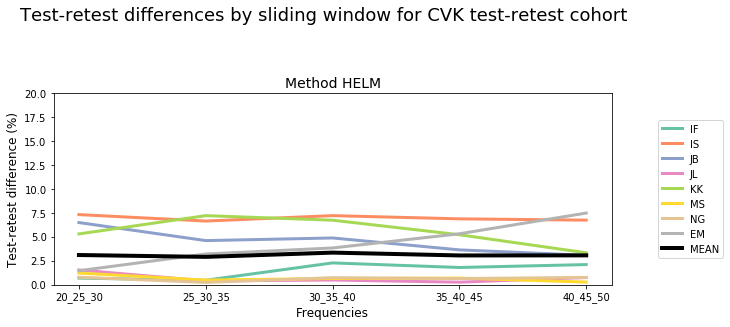

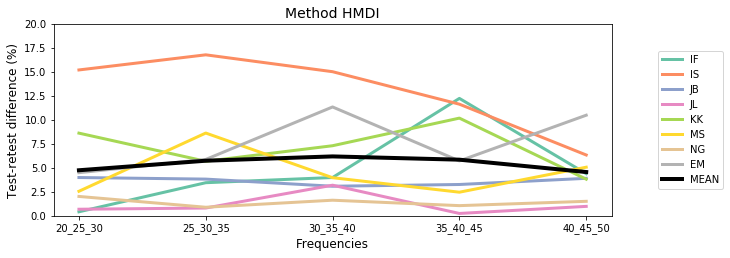

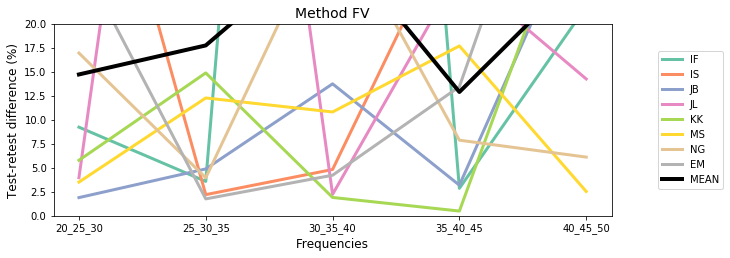

In [421]:
UNSORTED_ORDER = np.array([0,1,2,4,6,3,5])

def get_before_after_differences(g_set):
    before_after_differences = []
    for meth_idx, method in enumerate(g_set.method.unique()):
        for idx, subject in enumerate(g_set.subj.unique()):
            before_and_after = []
            for condition in ['before', 'after'] :
                g_subj_cond = g_set[(g_set['subj'] == subject) & (g_set['cond'] == condition)
                                       & (g_set['method'] == method)]
                g_subj_cond = g_subj_cond.reset_index(drop=True)
                before_and_after.append(g_subj_cond)
            before_after_difference = before_and_after[0]
            before_after_difference.G = abs(before_and_after[1].G - before_and_after[0].G) / before_and_after[0].G * 100 
            before_after_difference = before_after_difference.drop(columns=['cond', 'subj_ID', 'subj_cond'])
            before_after_differences.append(before_after_difference)
    return pd.concat(before_after_differences)

def plot_before_after_differences(before_after_differences, unsort_mean=False,ylims=[0, 20]):
    color_cycler_2 = cycler('color', color_scheme)
    plt.rcParams["figure.figsize"] = (10,12)
    fig_sup, ax = plt.subplots(1,1)
    tick_labels = list(before_after_differences.freqs.unique())
    legend_entries = []
    fig_sup.suptitle("Test-retest differences by sliding window for CVK test-retest cohort", fontsize=18)

    for meth_idx, method in enumerate(before_after_differences.method.unique()):
        before_after_bymeth = before_after_differences[before_after_differences['method'] == method]
        ax = plt.subplot(3, 1, meth_idx+1)
        plt.gca().set_prop_cycle(color_cycler_2)
        ax.set_xticks(range(len(tick_labels)))
        ax.set_xticklabels(tick_labels, minor=False)
        ax.set_ylim(ylims)
        for idx, subject in enumerate(before_after_bymeth.subj.unique()):
            legend_entries.append(subject)
            g_diff = before_after_bymeth[before_after_bymeth['subj'] == subject]
            g_diff = g_diff.reset_index()
            plt.plot(g_diff.G, lw=3)
        mean_line = before_after_bymeth.groupby('freqs').mean().G
        #print(mean_line)
        #mean_line = mean_line.values[:,0]
        if unsort_mean:
            mean_line = mean_line[UNSORTED_ORDER]
        legend_entries.append('MEAN')
        plt.plot(mean_line, lw=4, color='black')
        plt.legend(legend_entries, loc='right', bbox_to_anchor=(1.2,0.5), borderaxespad=0)
        plt.xlabel('Frequencies', fontsize=12)
        plt.ylabel(r"Test-retest difference (%)", fontsize=12)
        plt.title("Method" + " " + method.upper(), fontsize=14)
        plt.show()

before_after_sliding = get_before_after_differences(g_medians_sliding)
plot_before_after_differences(before_after_sliding)

# Just to be clear, we are not looking at stiffness increasing or decreasing with time, but consistency between test and retest getting worse. 

3 main observations:

- MREdge-HELM is clearly stabler than HMDI here. Keeping every other aspect of the inversion exactly the same, the HMDI inversion is sensitive to something that HELM is just not. This is particularly surprising since HMDI can easily be shown to be more noise-robust than HELM in simulation testing. So what is it?

- Overall the lower frequencies are stabler than the higher frequencies, but there is some zig-zagging. The frequencies were acquired [20, 25, 30, 40, 50, 35, 45]. From these data we cannot sort out in these charts whether it was acquisition order (more movement as the accquisition went on) or frequency that causes the growing instability. 

- And, obviously, the FV method still has stability problems and will be dropped from the remaining analyses until regularisation is in place.

My guess so far is, just like with abdomen, movement by the patient causes the images to blur and the values to drop. Since the only difference is inversion method, I think that HMDI's global solver is affected by patient motion more than a purely local solver. (If it gives you hope for the future, recall that the finite-volume solver is the most local of all.)

# Wideband individual frequencies

First we plot elasticity results by frequency. Again, HELM steadiness over the frequencies is very impressive. Again, HELM and HMDI agree on who is stiffest and who is softest,  but HELM is more stable. Also, HMDI appears to be getting too high at 50Hz:

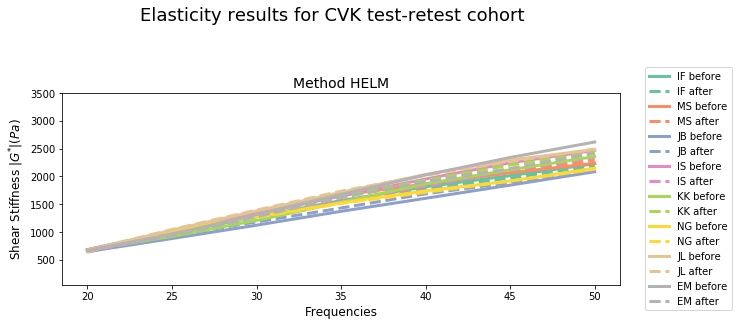

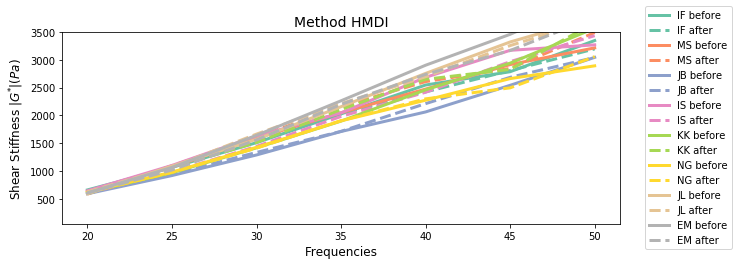

In [406]:

# drop fv and phi methods / values
g_medians_indiv = g_medians[(g_medians.method != 'fv') &  (g_medians.method != 'phi')]

g_medians_indiv_sorted = g_medians_indiv[g_medians_indiv.freq_test == 1].sort_values('freqs')
plot_frequency_subset(g_medians_indiv_sorted)


The HELM image is particularly stable and convincing. This is good news for the MREdge pipeline going forward, as some groups request that in multifrequency MRE, the values at each frequency are reported. This chart shows that the new protol and pipline can do this in a very stable way.

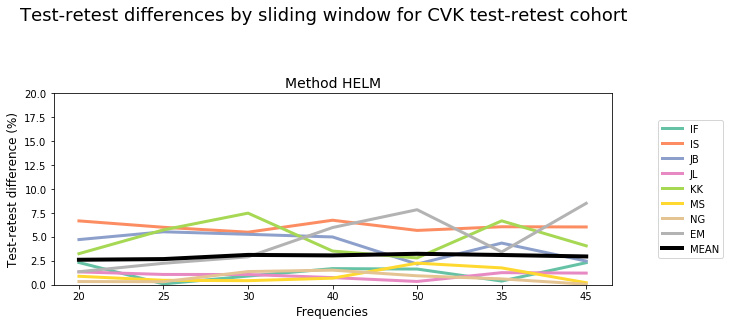

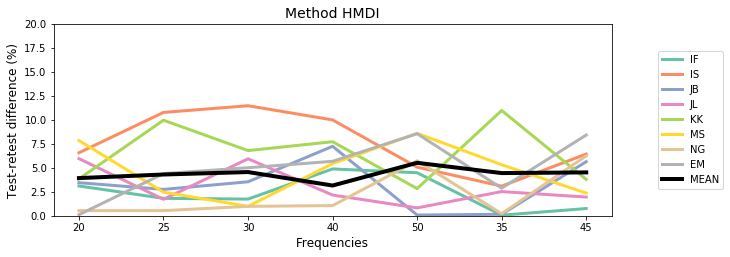

In [407]:
g_byfreq_unsorted = g_medians_indiv[g_medians_indiv.freq_test == 1]
g_byfreq_unsorted_before_after = get_before_after_differences(g_byfreq_unsorted)
plot_before_after_differences(g_byfreq_unsorted_before_after)

The test-retest differences appear to show no particular relation to frequency or lateness in the cycle.

The mean line in the HELM acquisitions is now essentially linear. The wideband data thus strongly suggest that test-retest accuracy is dependent on *frequency* rather than *placement* in the acquisition sequence. 

# Narrowband

We now look at narrowband data, in which the same frequency was acquired 5 times in a row. For a labeling convention, the five acquisitions are labelled as 25, 25.01, 25.02, 25.03 and 25.04 respectively; however the true frequency was always the same, 25 Hz.

In this case there is no meaning to the sliding windows or to the sorting of frequencies, so we just look at the data set in the acquired order, and stick with HELM:

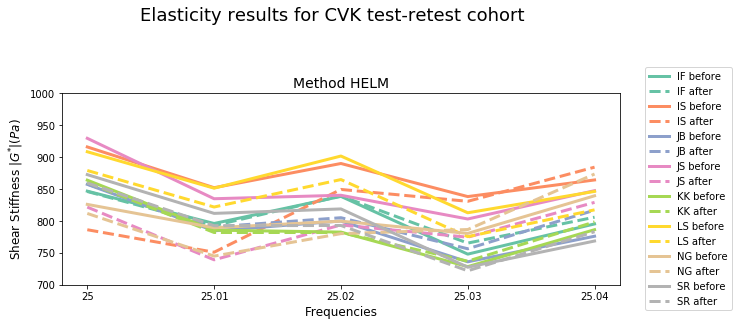

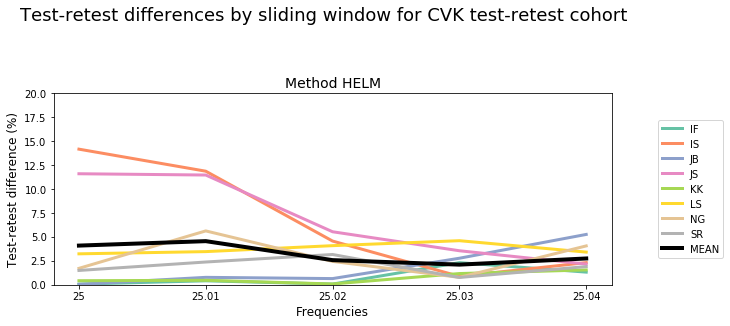

In [439]:
g_narrow = process_results(NARROWBAND_RESULTS_PATH)
g_narrow_helm = g_narrow[g_narrow.method == 'helm']
#g_narrow = g_narrow[(g_narrow.method == 'helm') | (g_narrow.method == 'hmdi')]
g_narrow_byfreq = g_narrow_helm[g_narrow_helm.freq_test == 1]
plot_frequency_subset(g_narrow_byfreq, ylims =[700, 1000])
g_narrow_byfreq_before_after = get_before_after_differences(g_narrow_byfreq)
plot_before_after_differences(g_narrow_byfreq_before_after)

I see the following conclusions:

- The oscillation of the narrowband elasticity results across the five acquisitions is fascinating. From  other recent experiments, we are not surprised by the oscillation. But why would the particular up-down pattern be the same for all the subjects? That is, whatever drives this natural oscillation, laying the subject in the scanner appears to put them all "in phase".
- Here we see that test-retest results controlling for frequency are mostly extremely consistent, while two subjects show the *opposite* trend from above, that is, the reproducibility increases over the course of the acquisition and reaches a steady state. 

# Stability of $\phi$ and $G'$ variables

One possibility for the greater stability of HELM was that it is evaluated locally, however the FV method was not stabler despite it being evaluated locally. Another possibility is that the mathematics of HELM -- handling real magnitudes rather than complex values -- has a large stabilizing effect. I thus decided to look at Phi values as well as a storage modulus (G') value reconstructed from the combination of $|G^{*}|$ and $\phi$.

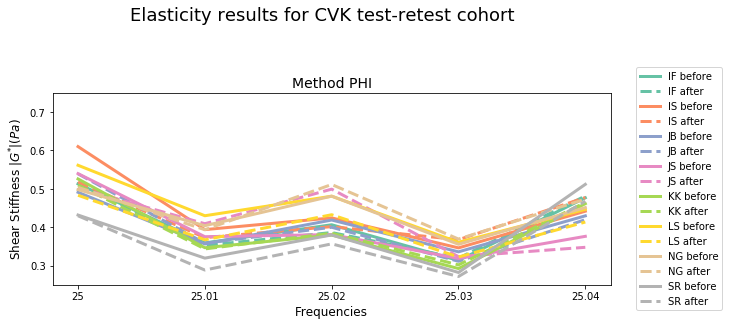

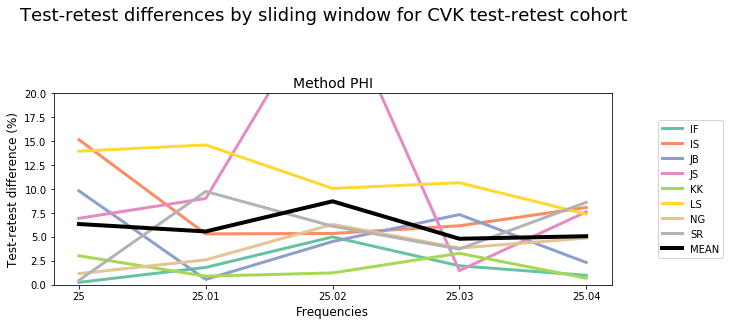

In [419]:
g_narrow_absg  = g_narrow[(g_narrow.method == 'helm') & (g_narrow.freq_test == 1)].reset_index()
g_narrow_phi = g_narrow[(g_narrow.method == 'phi') & (g_narrow.freq_test == 1)].reset_index()
g_narrow_storage = g_narrow_absg.merge(g_narrow_phi, on=['freqs', 'subj_ID', 'subj_cond'], how='outer',
                                      suffixes = ['_absg', '_phi'])
g_narrow_storage = pd.concat([g_narrow_absg, g_narrow_storage.G_phi], axis=1)

def storage(row) :
    storage = row['G']*np.cos(row['G_phi'])
    return storage


g_narrow_storage['G_storage'] = g_narrow_storage.apply(storage, axis=1)
g_narrow_storage = g_narrow_storage.drop(['G', 'G_phi'], axis=1)
g_narrow_storage.method='storage'
g_narrow_storage = g_narrow_storage.rename(columns={'G_storage':'G'})
plot_frequency_subset(g_narrow_phi, ylims=[0.25, 0.75])
plot_before_after_differences(get_before_after_differences(g_narrow_phi))

$\phi$ shows similar oscillations to $G$, although more pronounced. The test-retest profile is clearly quite different,the outliers are not all the same or at the same time points. Thus some of the test-retest differences in elasticity may be physiology rather than just motion. Also, the normalized test-retest differences are considerably larger, which could either be due to the instability of the variable, or the phase angle being more physiologically variant. Next I plot storage modulus $G'$:

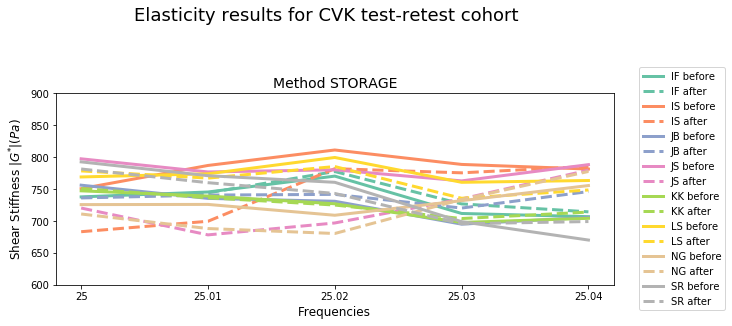

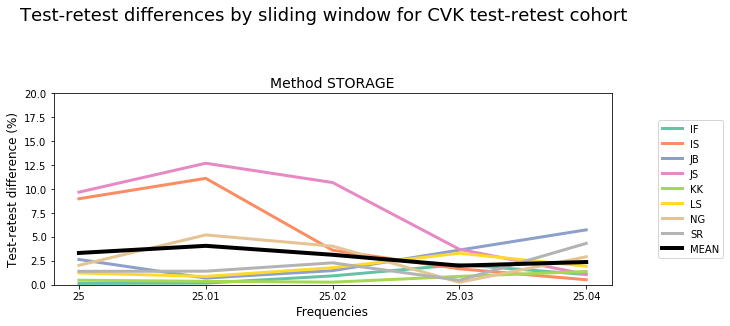

In [410]:
plot_frequency_subset(g_narrow_storage, ylims =[600, 900])
plot_before_after_differences(get_before_after_differences(g_narrow_storage))

Storage modulus in the narrowband case seems less stable. The next sections will look at the wideband results for $\phi$ and $G'$.

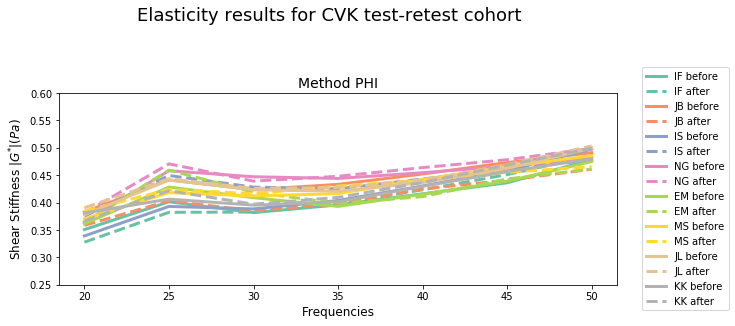

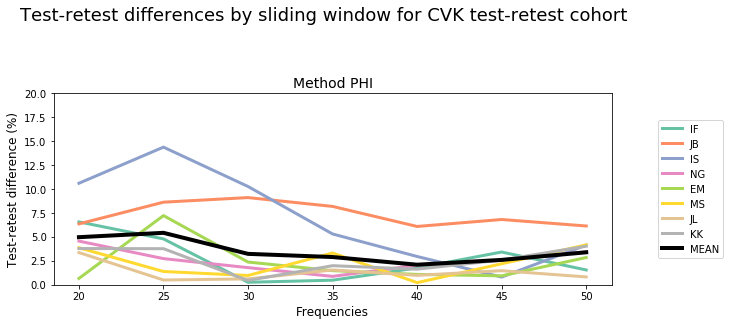

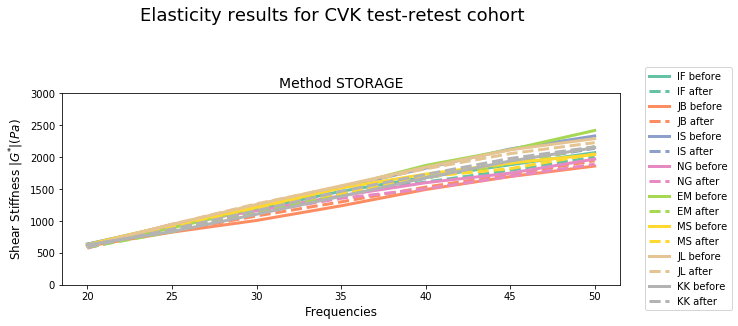

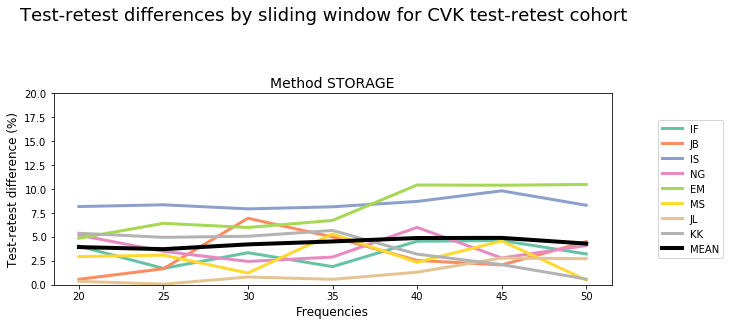

In [423]:
g_wide_absg  = g_medians[(g_medians.method == 'helm') & (g_medians.freq_test == 1)].reset_index().sort_values('freqs')
g_wide_phi = g_medians[(g_medians.method == 'phi') & (g_medians.freq_test == 1)].reset_index().sort_values('freqs')
g_wide_storage = g_wide_absg.merge(g_wide_phi, on=['freqs', 'subj_ID', 'subj_cond'], how='outer',
                                      suffixes = ['_absg', '_phi'])
g_wide_storage = pd.concat([g_wide_absg, g_wide_storage.G_phi], axis=1).sort_values('freqs')

def storage(row) :
    storage = row['G']*np.cos(row['G_phi'])
    return storage


g_wide_storage['G_storage'] = g_wide_storage.apply(storage, axis=1)
g_wide_storage = g_wide_storage.drop(['G', 'G_phi'], axis=1)
g_wide_storage.method='storage'
g_wide_storage = g_wide_storage.rename(columns={'G_storage':'G'})
plot_frequency_subset(g_wide_phi, ylims=[0.25, 0.6])
plot_before_after_differences(get_before_after_differences(g_wide_phi), ylims=[0, 20])
plot_frequency_subset(g_wide_storage, ylims =[0, 3000])
plot_before_after_differences(get_before_after_differences(g_wide_storage), ylims=[0, 20])

Storage modulus is slightly less stable than $|G*|$, but not dramatically. It shows the same frequency-dependent test-rest discrepancies, slightly worse.

# Test-Retest for combined broadband

Here we look at whether the combination of all frequencies improves test-retest discrepancies and what the ranges are.

In [412]:
# new function to split before-after data, one point per subject per condition
def split_before_after(g_all):
    g_all_before = g_all[g_all.cond=='before'].reset_index()
    g_all_after = g_all[g_all.cond=='after'].reset_index()
    g_before_after = g_all_after.merge(g_all_before, on=['subj'], suffixes=('', '_after'))
    g_before_after.G = abs(g_before_after.G - g_before_after.G_after)
    ncols = len(g_before_after.columns)
    g_before_after.drop(g_before_after.columns[range(int(ncols/2)+1, ncols, 1)], axis=1, inplace=True)
    g_before_after.cond = 'diff'
    return g_before_after


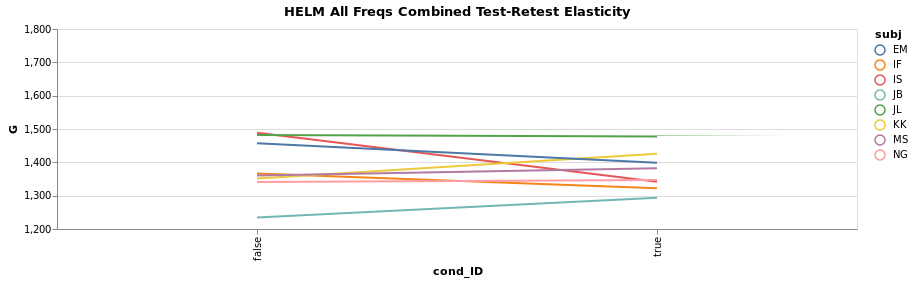

In [413]:
import altair as alt
alt.renderers.enable('notebook')

g_all_freqs = g_medians[g_medians.freq_test == 0]
DIFF_AXES = (0,400)

# need to repeat this code because of how Altair plots
method = 'helm'
g_method = g_all_freqs[g_all_freqs.method == method]
chart = alt.Chart(g_method).mark_line().encode(
    x= alt.X('cond_ID:N'),
    y= alt.Y('G:Q', 
             scale=alt.Scale(domain=(1200, 1800))), 
    color='subj'
).properties(width=800, height=200, title= method.upper() + ' All Freqs Combined Test-Retest Elasticity')
chart

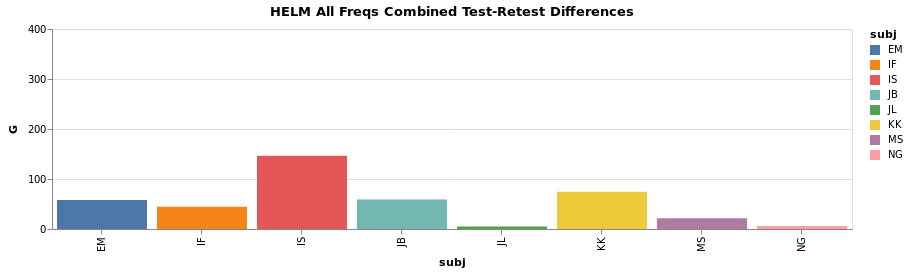

In [414]:
method = 'helm'
helm_ba = split_before_after(g_all_freqs[g_all_freqs.method == method])
chart = alt.Chart(helm_ba).mark_bar().encode(
    x= alt.X('subj:N'),
    y= alt.Y('G:Q', 
             scale=alt.Scale(domain=DIFF_AXES)), 
    color='subj'
).properties(width=800, height=200, title= method.upper() + ' All Freqs Combined Test-Retest Differences')
chart

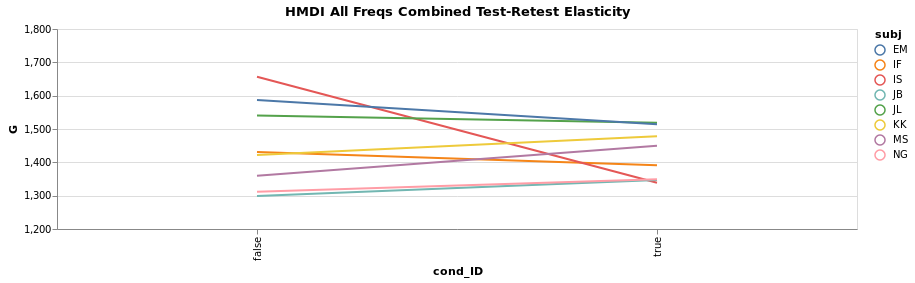

In [415]:
method = 'hmdi'
chart = alt.Chart(g_all_freqs[g_all_freqs.method == method]).mark_line().encode(
    x= alt.X('cond_ID:N'),
    y= alt.Y('G:Q', 
             scale=alt.Scale(domain=(1200, 1800))), 
    color='subj'
).properties(width=800, height=200, title= method.upper() + ' All Freqs Combined Test-Retest Elasticity')
chart

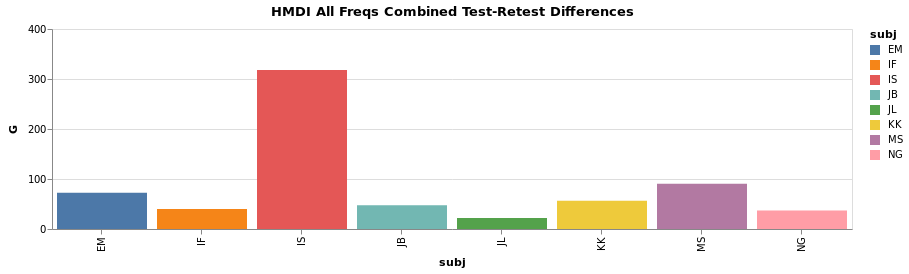

In [416]:
hmdi_ba = split_before_after(g_all_freqs[g_all_freqs.method == 'hmdi'])

chart = alt.Chart(hmdi_ba).mark_bar().encode(
    x= alt.X('subj:N'),
    y= alt.Y('G:Q', 
             scale=alt.Scale(domain=DIFF_AXES)), 
    color='subj'
).properties(width=800, height=200, title= method.upper() + ' All Freqs Combined Test-Retest Differences')
chart

Other than one very bad outlier (the mysterious subject IS), HMDI with all frequencies is comparably stable to MDEV, with medians nearly identical:

In [417]:
print('%s: %1.3f' % ('Mean HELM test-retest difference: ',helm_ba.groupby('subj').G.mean().mean()))
print('%s: %1.3f' % ('Mean HMDI test-retest difference: ',hmdi_ba.groupby('subj').G.mean().mean()))
print('%s: %1.3f' % ('Median HELM test-retest difference: ',helm_ba.groupby('subj').G.mean().median()))
print('%s: %1.3f' % ('Median HMDI test-retest difference: ',hmdi_ba.groupby('subj').G.mean().median()))

Mean HELM test-retest difference: : 51.944
Mean HMDI test-retest difference: : 85.440
Median HELM test-retest difference: : 51.429
Median HMDI test-retest difference: : 51.976


Broadband MRE does indeed seem to do its job of increasing overall reliability of the acquisition as compared to a single-frequency acquisition.

# Slicewise SNR for the acquisitions  - 3D Denoising

Here I investigated whether slicewise differences in displacement SNR are consistent across all acquisitions. The wideband data was investigated as there seemed no reason for narrowband to be different.

In [506]:
def get_slicewise_snr(WIDEBAND_RESULTS_PATH): 
    slicewise_snr = []
    stripper = (lambda col: col.strip())
    for dir in os.listdir(WIDEBAND_RESULTS_PATH):
        file_path = os.path.join(WIDEBAND_RESULTS_PATH, dir , 'stats/slicewise_snr.csv')
        slicewise_snr_subj = pd.read_csv(file_path, index_col=False)
        tile_dims = [slicewise_snr_subj.shape[0], 1]
        subj_id = np.tile(dir, tile_dims)
        subj = dir.split('_')[2]
        subj = np.tile(subj, tile_dims)
        slicewise_snr_subj['Subj_ID'] = subj_id
        slicewise_snr_subj['Subj'] = subj
        slicewise_snr.append(slicewise_snr_subj)
    slicewise_snr = pd.concat(slicewise_snr)
    slicewise_snr = slicewise_snr[slicewise_snr['Image'] != 'Image']
    slicewise_snr['Freq'] = pd.to_numeric(
            slicewise_snr['Image'].apply(lambda entry: str.split(str.split(entry, '.')[0], '/')[0]))
    slicewise_snr['Comp'] = pd.to_numeric(
            slicewise_snr['Image'].apply(lambda entry: str.split(str.split(entry, '.')[0], '/')[1]))
    slicewise_snr.columns = map(str.strip, slicewise_snr.columns)
    slicewise_snr = slicewise_snr.drop(columns=['Image'])
    slicewise_snr[['Slice', 'SNR']] = slicewise_snr[['Slice', 'SNR']].astype(float)
    return slicewise_snr

Below is a boxplot, showing SNR by slice for all acquisitions and frequencies lumped together. There appears to be a smooth overall trend, however with substantial errorbars. Tests of individual frequencies showed individual results to be similar to this plot.

[(20, 50)]

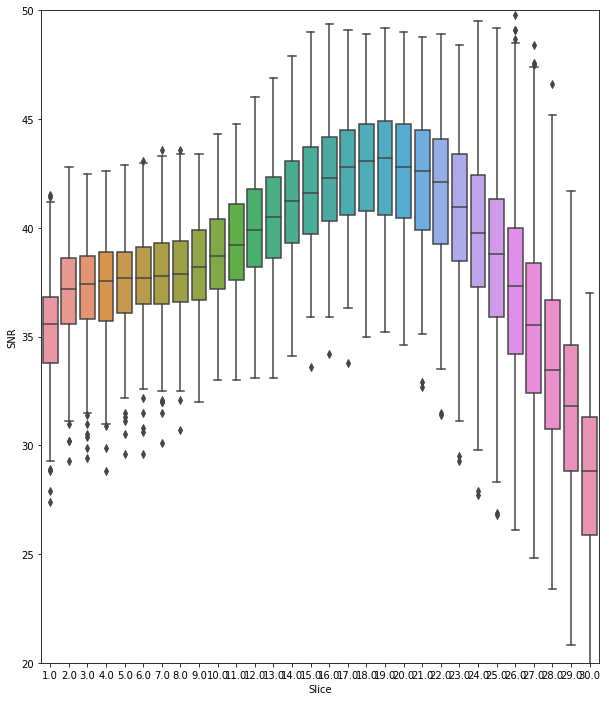

In [590]:
slicewise_snr = get_slicewise_snr(WIDEBAND_RESULTS_PATH)
g = sns.boxplot(x="Slice", y="SNR", data=slicewise_snr)
g.set(ylim=(20,50))

[comment]: # (So we next look at all the lines plotted to get a sense of the individual trends. Lines are colored by subject and stroke is by frequency, so see if any dependencies on either factor can be seen. First plot is for a single subject, second is for all subjects.)

In [592]:
%%capture
# prep styles for plots
subj_IDs = list(slicewise_snr.Subj.unique())
dic = zip(color_scheme, subj_IDs)
linestyles = ['-','--','-.',':','.',',','o']


In [593]:
%%capture
titles = ["Slicewise SNR - Single Subject", "Slicewise SNR - All Subjects"]
freq_ranges = [range(20,25,5), range(20,70,5)]
subj_ranges = [range(5,6,1), range(0, len(subj_IDs))]
for chart in range(2):
    plt.rcParams["figure.figsize"] = (10,12)
    fig_sup, ax = plt.subplots(1,1)
    tick_labels = list(g_medians.freqs.unique())
    fig_sup.suptitle(titles[chart], fontsize=18)
    for freq in freq_ranges[chart]:
        for subj in subj_ranges[chart]:
            for comp in range(1,4,1):
                line_data = slicewise_snr[(slicewise_snr['Freq'] == freq) & 
                                          (slicewise_snr['Subj'] == subj_IDs[subj]) & 
                                          (slicewise_snr['Comp'] == comp)].sort_values(['Slice'])
                plt.plot(line_data.Slice, line_data.SNR)
    plt.xlabel('Brain Slice', fontsize=12)
    plt.ylabel("Displacement SNR", fontsize=12)
    plt.show()
    plt.savefig('slicewise_snr.svg')

# Slicewise Denoising Then Dejitter (SDTD): SNR Results

First we look at elasticity and test-retest results using the SDTD pipeline order, to make sure the values are comparable. We plot HELM:

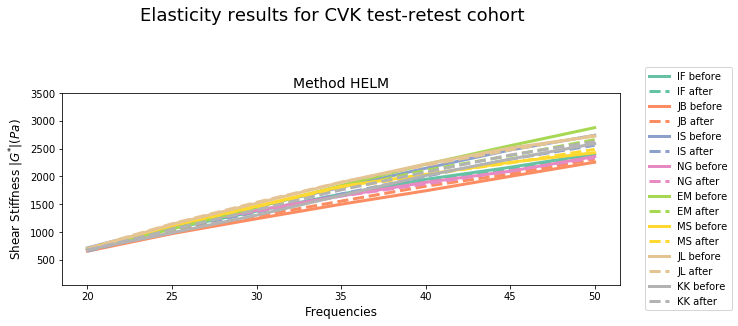

In [604]:
WIDEBAND_RESULTS_PATH_2D = '/media/ericbarnhill/backup/projects/2018-03-12-virchow/denoise_2d/results_wideband'
NARROWBAND_RESULTS_PATH_2D = '/media/ericbarnhill/backup/projects/2018-03-12-virchow/denoise_2d/results_narrowband/'

g_medians = process_results(WIDEBAND_RESULTS_PATH_2D)
g_medians_indiv = g_medians[(g_medians.method == 'helm')]
g_medians_indiv_sorted = g_medians_indiv[g_medians_indiv.freq_test == 1].sort_values('freqs')
plot_frequency_subset(g_medians_indiv_sorted)

Results are very similar to the 3D denoise, though the range on top extends slightly higher (more noise-robustness?).

[(20, 50)]

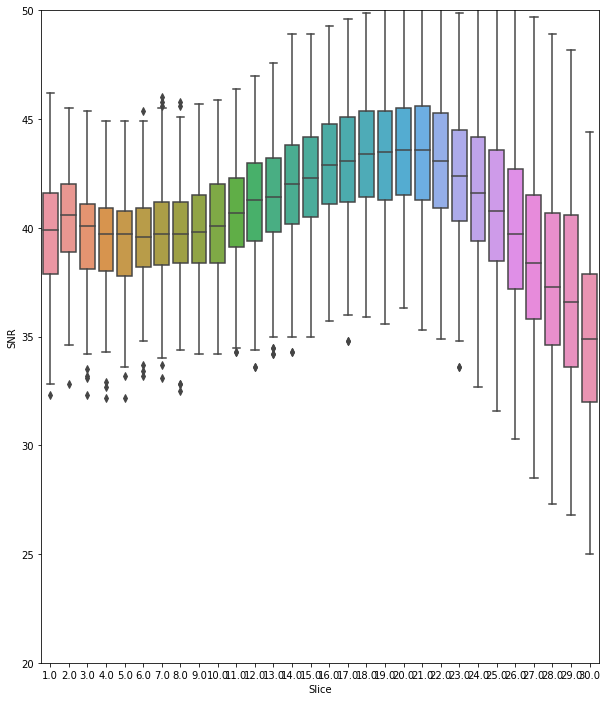

In [605]:
slicewise_snr_2d = get_slicewise_snr(WIDEBAND_RESULTS_PATH_2D)
g = sns.boxplot(x="Slice", y="SNR", data=slicewise_snr_2d)
g.set(ylim=(20,50))

This shows a much improved snr on the lower end of 35-45 as opposed to the 28-45 above. This explains the higher values at higher frequencies; it is indeed because the 2D denoising appears more noise-robust. Interestingly, the pattern is effectively the same, so whatever causes the shifting SNR is not effected by this improvement. Consequently the 2D followed by dejitter is both faster and gives improved SNR, and this should  be adopted in the pipeline.

# Does inter-subject variability depend on frequency?

Here we see if there is greater inter-subject variability by frequency, by normalizing each value of each frequency to the mean of the values obtained at that frequency. Note: shear modulus values on the left are normalized.

In [594]:
def normalize_by_frequency(df):
    freq_means = df.groupby('freqs').mean()
    freqs = freq_means.index
    for freq in freqs:
        df_freq = df['freqs'] == freq
        df_norm = df.loc[df_freq,'G']
        df_norm = df_norm / freq_means.loc[freq,'G']
        df.loc[df_freq,'G'] = df_norm
    return df

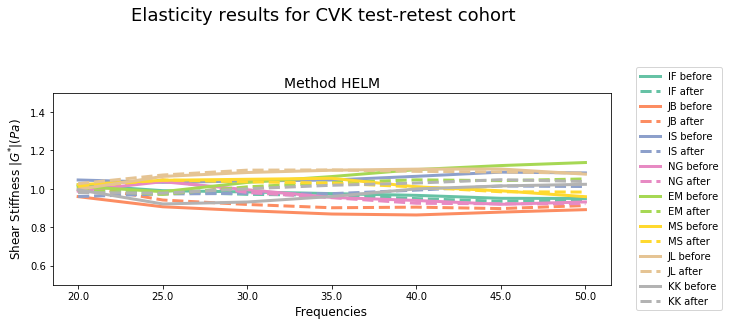

In [599]:
g = g_medians_indiv_sorted
g_norm = normalize_by_frequency(g)
plot_frequency_subset(g_norm, ylims=[0.5, 1.5])

This suggests that starting from approximately 30Hz, inter-subject variability does not change appreciably by frequency. However at the very low frequencies, particularly 20Hz there does seem to be a tighter grouping. Recalling that $|G*|$ is a combination of elasticity and viscosity, one possibility is that viscosity changes are driving most of the inter-individual differences. We can check the storage modulus to see if this idea is supported:

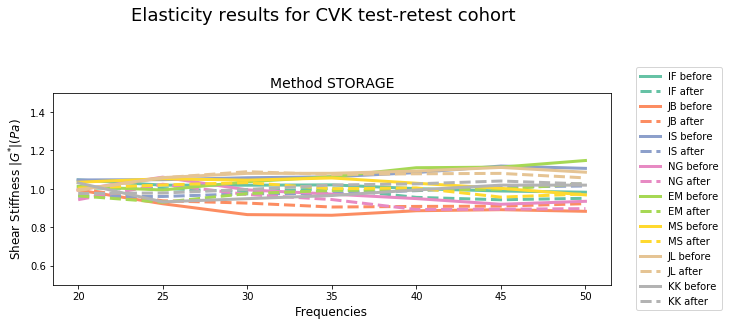

In [601]:
plot_frequency_subset(normalize_by_frequency(g_wide_storage), ylims=[0.5, 1.5])

Results are almost exactly the same. So either this isn't it or storage is not a good proxy here.